In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pytransit import QuadraticModel
from decimal import Decimal
import emcee
import corner
from IPython.display import display, Math
import csv 
from numpy import savetxt
from numpy import loadtxt
from numpy import random
from multiprocessing import Pool
from transitleastsquares import transitleastsquares
import batman
import statistics
from statistics import mode
import pandas as pd
from tabulate import tabulate
from stochastic.processes.base import BaseTimeProcess
from stochastic.utils.validation import check_numeric
from stochastic.utils.validation import check_positive_integer
from stochastic.processes.noise import ColoredNoise
from stochastic.processes.noise import GaussianNoise

import seaborn as sns

How many periods? 2
[ 5. 10.]
How many rp_over_rstars? 2
[0.0155 0.016 ]
How many times to run each block? 2


/Users/danayaptangco/opt/anaconda3/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)

  0%|          | 0/2458 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 38 durations
Searching 19439 data points, 2458 periods from 0.602 to 13.499 days
Using all 4 CPU threads


 28%|██▊       | 697/2458 periods | 00:50<01:30
  0%|          | 1/2458 periods | 00:15<10:42:18
  0%|          | 2/2458 periods | 00:15<4:28:11 
  0%|          | 4/2458 periods | 00:15<1:41:30
  0%|          | 6/2458 periods | 00:16<55:02  
  0%|          | 8/2458 periods | 00:16<34:08
  0%|          | 10/2458 periods | 00:16<22:31
  0%|          | 12/2458 periods | 00:16<16:07
  1%|          | 14/2458 periods | 00:16<11:34
  1%|          | 16/2458 periods | 00:16<08:59
  1%|          | 18/2458 periods | 00:17<07:02
  1%|          | 20/2458 periods | 00:17<05:51
  1%|          | 22/2458 periods | 00:17<05:17
  1%|          | 24/2458 periods | 00:17<04:54
  1%|          | 27/2458 periods | 00:17<04:13
  1%|          | 30/2458 periods | 00:17<03:17
  1%|▏         | 32/2458 periods | 00:18<03:26
  1%|▏         | 35/2458 periods | 00:18<03:06
  2%|▏         | 39/2458 periods | 00:18<02:40
  2%|▏         | 41/2458 periods | 00:18<02:36
  2%|▏         | 43/2458 periods | 00:18<02:27
  2%|▏ 

 15%|█▌        | 378/2458 periods | 00:44<03:13
 15%|█▌        | 380/2458 periods | 00:44<02:56
 16%|█▌        | 382/2458 periods | 00:45<03:14
 16%|█▌        | 385/2458 periods | 00:45<03:01
 16%|█▌        | 388/2458 periods | 00:45<02:30
 16%|█▌        | 390/2458 periods | 00:45<02:25
 16%|█▌        | 392/2458 periods | 00:45<02:33
 16%|█▌        | 394/2458 periods | 00:45<02:40
 16%|█▌        | 397/2458 periods | 00:46<02:26
 16%|█▌        | 399/2458 periods | 00:46<02:44
 16%|█▋        | 401/2458 periods | 00:46<02:50
 16%|█▋        | 403/2458 periods | 00:46<03:06
 16%|█▋        | 405/2458 periods | 00:47<03:53
 17%|█▋        | 406/2458 periods | 00:47<04:18
 17%|█▋        | 408/2458 periods | 00:47<03:28
 17%|█▋        | 410/2458 periods | 00:47<03:35
 17%|█▋        | 412/2458 periods | 00:47<03:04
 17%|█▋        | 414/2458 periods | 00:48<03:38
 17%|█▋        | 416/2458 periods | 00:48<03:15
 17%|█▋        | 418/2458 periods | 00:48<03:31
 17%|█▋        | 420/2458 periods | 00:4

 29%|██▉       | 713/2458 periods | 01:19<12:01
 29%|██▉       | 714/2458 periods | 01:20<09:49
 29%|██▉       | 716/2458 periods | 01:20<08:15
 29%|██▉       | 718/2458 periods | 01:20<07:07
 29%|██▉       | 720/2458 periods | 01:21<06:17
 29%|██▉       | 721/2458 periods | 01:21<06:20
 29%|██▉       | 722/2458 periods | 01:21<06:56
 29%|██▉       | 723/2458 periods | 01:21<06:26
 29%|██▉       | 724/2458 periods | 01:22<07:44
 30%|██▉       | 727/2458 periods | 01:22<06:20
 30%|██▉       | 728/2458 periods | 01:23<06:06
 30%|██▉       | 729/2458 periods | 01:23<05:54
 30%|██▉       | 731/2458 periods | 01:23<05:06
 30%|██▉       | 732/2458 periods | 01:23<05:11
 30%|██▉       | 733/2458 periods | 01:23<06:06
 30%|██▉       | 735/2458 periods | 01:24<05:15
 30%|██▉       | 736/2458 periods | 01:24<05:00
 30%|███       | 738/2458 periods | 01:24<03:52
 30%|███       | 739/2458 periods | 01:24<04:38
 30%|███       | 741/2458 periods | 01:24<03:35
 30%|███       | 743/2458 periods | 01:2

 43%|████▎     | 1051/2458 periods | 01:53<01:41
 43%|████▎     | 1055/2458 periods | 01:53<01:41
 43%|████▎     | 1058/2458 periods | 01:53<01:34
 43%|████▎     | 1060/2458 periods | 01:53<02:12
 43%|████▎     | 1062/2458 periods | 01:54<02:28
 43%|████▎     | 1064/2458 periods | 01:54<02:47
 43%|████▎     | 1066/2458 periods | 01:54<02:31
 43%|████▎     | 1068/2458 periods | 01:54<02:20
 44%|████▎     | 1070/2458 periods | 01:54<02:18
 44%|████▎     | 1072/2458 periods | 01:55<02:20
 44%|████▎     | 1074/2458 periods | 01:55<02:12
 44%|████▍     | 1077/2458 periods | 01:55<01:55
 44%|████▍     | 1079/2458 periods | 01:55<01:57
 44%|████▍     | 1081/2458 periods | 01:55<01:52
 44%|████▍     | 1083/2458 periods | 01:55<01:49
 44%|████▍     | 1086/2458 periods | 01:56<01:41
 44%|████▍     | 1088/2458 periods | 01:56<01:38
 44%|████▍     | 1090/2458 periods | 01:56<01:45
 44%|████▍     | 1092/2458 periods | 01:56<01:44
 45%|████▍     | 1094/2458 periods | 01:56<01:56
 45%|████▍     | 109

 57%|█████▋    | 1411/2458 periods | 02:20<01:35
 57%|█████▋    | 1413/2458 periods | 02:20<01:39
 58%|█████▊    | 1415/2458 periods | 02:20<01:31
 58%|█████▊    | 1417/2458 periods | 02:21<01:36
 58%|█████▊    | 1420/2458 periods | 02:21<01:20
 58%|█████▊    | 1422/2458 periods | 02:21<01:22
 58%|█████▊    | 1424/2458 periods | 02:21<01:17
 58%|█████▊    | 1426/2458 periods | 02:21<01:23
 58%|█████▊    | 1428/2458 periods | 02:21<01:16
 58%|█████▊    | 1430/2458 periods | 02:22<01:33
 58%|█████▊    | 1432/2458 periods | 02:22<01:26
 58%|█████▊    | 1434/2458 periods | 02:22<01:32
 58%|█████▊    | 1436/2458 periods | 02:22<01:29
 59%|█████▊    | 1438/2458 periods | 02:22<01:42
 59%|█████▊    | 1440/2458 periods | 02:23<01:40
 59%|█████▊    | 1442/2458 periods | 02:23<01:51
 59%|█████▊    | 1443/2458 periods | 02:23<01:57
 59%|█████▉    | 1445/2458 periods | 02:23<01:54
 59%|█████▉    | 1449/2458 periods | 02:23<01:25
 59%|█████▉    | 1451/2458 periods | 02:23<01:17
 59%|█████▉    | 145

 77%|███████▋  | 1887/2458 periods | 02:44<00:23
 77%|███████▋  | 1890/2458 periods | 02:44<00:22
 77%|███████▋  | 1894/2458 periods | 02:44<00:21
 77%|███████▋  | 1898/2458 periods | 02:45<00:20
 77%|███████▋  | 1901/2458 periods | 02:45<00:20
 78%|███████▊  | 1905/2458 periods | 02:45<00:18
 78%|███████▊  | 1909/2458 periods | 02:45<00:17
 78%|███████▊  | 1913/2458 periods | 02:45<00:17
 78%|███████▊  | 1917/2458 periods | 02:45<00:18
 78%|███████▊  | 1921/2458 periods | 02:45<00:17
 78%|███████▊  | 1925/2458 periods | 02:45<00:17
 78%|███████▊  | 1929/2458 periods | 02:46<00:16
 79%|███████▊  | 1933/2458 periods | 02:46<00:17
 79%|███████▉  | 1937/2458 periods | 02:46<00:16
 79%|███████▉  | 1941/2458 periods | 02:46<00:18
 79%|███████▉  | 1944/2458 periods | 02:46<00:19
 79%|███████▉  | 1947/2458 periods | 02:46<00:22
 79%|███████▉  | 1951/2458 periods | 02:46<00:19
 79%|███████▉  | 1954/2458 periods | 02:47<00:21
 80%|███████▉  | 1957/2458 periods | 02:47<00:22
 80%|███████▉  | 196

 99%|█████████▊| 2426/2458 periods | 03:05<00:01
 99%|█████████▉| 2429/2458 periods | 03:05<00:01
 99%|█████████▉| 2432/2458 periods | 03:05<00:01
 99%|█████████▉| 2436/2458 periods | 03:05<00:00
 99%|█████████▉| 2441/2458 periods | 03:05<00:00
 99%|█████████▉| 2445/2458 periods | 03:05<00:00
100%|█████████▉| 2448/2458 periods | 03:06<00:00
100%|█████████▉| 2452/2458 periods | 03:06<00:00
100%|██████████| 2458/2458 periods | 03:06<00:00

  0%|          | 0/5837 [00:00<?, ?it/s]

Searching for best T0 for period 4.99722 days



100%|██████████| 5837/5837 [00:04<00:00, 1338.88it/s]
/Users/danayaptangco/opt/anaconda3/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)

  0%|          | 0/2458 periods | 00:00<?

[]
Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 38 durations
Searching 19439 data points, 2458 periods from 0.602 to 13.499 days
Using all 4 CPU threads



  0%|          | 1/2458 periods | 00:13<9:27:29
  0%|          | 4/2458 periods | 00:13<1:48:47
  0%|          | 8/2458 periods | 00:14<43:40  
  0%|          | 12/2458 periods | 00:14<24:20
  1%|          | 16/2458 periods | 00:14<15:20
  1%|          | 19/2458 periods | 00:14<11:14
  1%|          | 22/2458 periods | 00:14<08:28
  1%|          | 25/2458 periods | 00:14<06:34
  1%|          | 28/2458 periods | 00:15<05:04
  1%|▏         | 31/2458 periods | 00:15<04:18
  1%|▏         | 34/2458 periods | 00:15<03:25
  2%|▏         | 37/2458 periods | 00:15<02:52
  2%|▏         | 40/2458 periods | 00:15<03:17
  2%|▏         | 43/2458 periods | 00:15<02:50
  2%|▏         | 46/2458 periods | 00:16<02:25
  2%|▏         | 49/2458 periods | 00:16<02:14
  2%|▏         | 52/2458 periods | 00:16<02:05
  2%|▏         | 55/2458 periods | 00:16<01:53
  2%|▏         | 59/2458 periods | 00:16<01:53
  3%|▎         | 63/2458 periods | 00:16<01:53
  3%|▎         | 66/2458 periods | 00:16<01:57
  3%|▎   

 21%|██        | 521/2458 periods | 00:36<01:20
 21%|██▏       | 525/2458 periods | 00:36<01:16
 22%|██▏       | 529/2458 periods | 00:36<01:09
 22%|██▏       | 532/2458 periods | 00:36<01:11
 22%|██▏       | 535/2458 periods | 00:36<01:14
 22%|██▏       | 538/2458 periods | 00:36<01:14
 22%|██▏       | 542/2458 periods | 00:36<01:16
 22%|██▏       | 546/2458 periods | 00:36<01:07
 22%|██▏       | 549/2458 periods | 00:37<01:06
 22%|██▏       | 553/2458 periods | 00:37<01:02
 23%|██▎       | 557/2458 periods | 00:37<01:05
 23%|██▎       | 560/2458 periods | 00:37<01:10
 23%|██▎       | 563/2458 periods | 00:37<01:15
 23%|██▎       | 567/2458 periods | 00:37<01:10
 23%|██▎       | 571/2458 periods | 00:37<01:05
 23%|██▎       | 574/2458 periods | 00:37<01:05
 23%|██▎       | 577/2458 periods | 00:38<01:05
 24%|██▎       | 581/2458 periods | 00:38<01:08
 24%|██▍       | 585/2458 periods | 00:38<01:02
 24%|██▍       | 589/2458 periods | 00:38<01:03
 24%|██▍       | 593/2458 periods | 00:3

 43%|████▎     | 1060/2458 periods | 00:57<01:08
 43%|████▎     | 1063/2458 periods | 00:58<01:07
 43%|████▎     | 1066/2458 periods | 00:58<01:04
 43%|████▎     | 1069/2458 periods | 00:58<01:08
 44%|████▎     | 1072/2458 periods | 00:58<01:05
 44%|████▎     | 1075/2458 periods | 00:58<01:08
 44%|████▍     | 1079/2458 periods | 00:58<00:57
 44%|████▍     | 1082/2458 periods | 00:58<00:57
 44%|████▍     | 1085/2458 periods | 00:59<00:58
 44%|████▍     | 1089/2458 periods | 00:59<00:55
 44%|████▍     | 1092/2458 periods | 00:59<00:59
 45%|████▍     | 1095/2458 periods | 00:59<00:57
 45%|████▍     | 1098/2458 periods | 00:59<00:57
 45%|████▍     | 1101/2458 periods | 00:59<01:08
 45%|████▍     | 1104/2458 periods | 00:59<01:06
 45%|████▌     | 1107/2458 periods | 01:00<01:03
 45%|████▌     | 1110/2458 periods | 01:00<01:17
 45%|████▌     | 1112/2458 periods | 01:00<01:18
 45%|████▌     | 1114/2458 periods | 01:00<01:25
 45%|████▌     | 1117/2458 periods | 01:00<01:18
 46%|████▌     | 112

 64%|██████▎   | 1566/2458 periods | 01:19<00:38
 64%|██████▍   | 1569/2458 periods | 01:19<00:41
 64%|██████▍   | 1573/2458 periods | 01:19<00:38
 64%|██████▍   | 1577/2458 periods | 01:19<00:35
 64%|██████▍   | 1580/2458 periods | 01:19<00:37
 64%|██████▍   | 1584/2458 periods | 01:20<00:34
 65%|██████▍   | 1588/2458 periods | 01:20<00:33
 65%|██████▍   | 1592/2458 periods | 01:20<00:32
 65%|██████▍   | 1595/2458 periods | 01:20<00:32
 65%|██████▌   | 1598/2458 periods | 01:20<00:31
 65%|██████▌   | 1601/2458 periods | 01:20<00:33
 65%|██████▌   | 1605/2458 periods | 01:20<00:30
 65%|██████▌   | 1608/2458 periods | 01:20<00:33
 66%|██████▌   | 1611/2458 periods | 01:21<00:32
 66%|██████▌   | 1614/2458 periods | 01:21<00:33
 66%|██████▌   | 1617/2458 periods | 01:21<00:32
 66%|██████▌   | 1620/2458 periods | 01:21<00:32
 66%|██████▌   | 1624/2458 periods | 01:21<00:30
 66%|██████▋   | 1629/2458 periods | 01:21<00:28
 66%|██████▋   | 1632/2458 periods | 01:21<00:29
 67%|██████▋   | 163

 85%|████████▍ | 2078/2458 periods | 01:40<00:14
 85%|████████▍ | 2081/2458 periods | 01:40<00:14
 85%|████████▍ | 2084/2458 periods | 01:41<00:14
 85%|████████▍ | 2088/2458 periods | 01:41<00:13
 85%|████████▌ | 2091/2458 periods | 01:41<00:13
 85%|████████▌ | 2094/2458 periods | 01:41<00:13
 85%|████████▌ | 2098/2458 periods | 01:41<00:12
 86%|████████▌ | 2102/2458 periods | 01:41<00:12
 86%|████████▌ | 2106/2458 periods | 01:41<00:11
 86%|████████▌ | 2110/2458 periods | 01:41<00:12
 86%|████████▌ | 2113/2458 periods | 01:42<00:13
 86%|████████▌ | 2117/2458 periods | 01:42<00:13
 86%|████████▋ | 2121/2458 periods | 01:42<00:12
 86%|████████▋ | 2125/2458 periods | 01:42<00:11
 87%|████████▋ | 2128/2458 periods | 01:42<00:12
 87%|████████▋ | 2131/2458 periods | 01:42<00:12
 87%|████████▋ | 2135/2458 periods | 01:42<00:13
 87%|████████▋ | 2139/2458 periods | 01:43<00:12
 87%|████████▋ | 2143/2458 periods | 01:43<00:11
 87%|████████▋ | 2146/2458 periods | 01:43<00:11
 87%|████████▋ | 214

Searching for best T0 for period 4.99722 days



100%|██████████| 5311/5311 [00:03<00:00, 1361.93it/s]


[]
Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 38 durations


/Users/danayaptangco/opt/anaconda3/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)

  0%|          | 0/2458 periods | 00:00<?

Searching 19439 data points, 2458 periods from 0.602 to 13.499 days
Using all 4 CPU threads



  0%|          | 1/2458 periods | 00:08<5:42:49
  0%|          | 4/2458 periods | 00:08<1:06:02
  0%|          | 7/2458 periods | 00:08<31:21  
  0%|          | 10/2458 periods | 00:08<18:24
  1%|          | 13/2458 periods | 00:08<12:01
  1%|          | 16/2458 periods | 00:08<08:19
  1%|          | 19/2458 periods | 00:09<06:04
  1%|          | 23/2458 periods | 00:09<04:10
  1%|          | 27/2458 periods | 00:09<03:03
  1%|▏         | 31/2458 periods | 00:09<02:30
  1%|▏         | 34/2458 periods | 00:09<02:13
  2%|▏         | 37/2458 periods | 00:09<02:04
  2%|▏         | 41/2458 periods | 00:09<01:45
  2%|▏         | 44/2458 periods | 00:09<01:42
  2%|▏         | 48/2458 periods | 00:10<01:29
  2%|▏         | 52/2458 periods | 00:10<01:28
  2%|▏         | 56/2458 periods | 00:10<01:21
  2%|▏         | 60/2458 periods | 00:10<01:22
  3%|▎         | 64/2458 periods | 00:10<01:23
  3%|▎         | 68/2458 periods | 00:10<01:17
  3%|▎         | 72/2458 periods | 00:10<01:22
  3%|▎   

 22%|██▏       | 549/2458 periods | 00:30<01:23
 22%|██▏       | 553/2458 periods | 00:30<01:16
 23%|██▎       | 556/2458 periods | 00:30<01:15
 23%|██▎       | 560/2458 periods | 00:30<01:06
 23%|██▎       | 563/2458 periods | 00:30<01:10
 23%|██▎       | 567/2458 periods | 00:30<01:04
 23%|██▎       | 570/2458 periods | 00:31<01:08
 23%|██▎       | 575/2458 periods | 00:31<01:05
 24%|██▎       | 579/2458 periods | 00:31<01:04
 24%|██▎       | 583/2458 periods | 00:31<01:06
 24%|██▍       | 587/2458 periods | 00:31<01:02
 24%|██▍       | 591/2458 periods | 00:31<01:01
 24%|██▍       | 595/2458 periods | 00:31<01:03
 24%|██▍       | 599/2458 periods | 00:31<01:01
 25%|██▍       | 603/2458 periods | 00:32<00:58
 25%|██▍       | 607/2458 periods | 00:32<00:59
 25%|██▍       | 611/2458 periods | 00:32<00:58
 25%|██▌       | 615/2458 periods | 00:32<00:58
 25%|██▌       | 619/2458 periods | 00:32<01:00
 25%|██▌       | 623/2458 periods | 00:32<01:02
 25%|██▌       | 626/2458 periods | 00:3

 45%|████▌     | 1109/2458 periods | 00:51<00:48
 45%|████▌     | 1112/2458 periods | 00:52<00:47
 45%|████▌     | 1116/2458 periods | 00:52<00:45
 46%|████▌     | 1119/2458 periods | 00:52<00:45
 46%|████▌     | 1122/2458 periods | 00:52<00:46
 46%|████▌     | 1126/2458 periods | 00:52<00:42
 46%|████▌     | 1130/2458 periods | 00:52<00:39
 46%|████▌     | 1134/2458 periods | 00:52<00:43
 46%|████▋     | 1138/2458 periods | 00:52<00:45
 46%|████▋     | 1141/2458 periods | 00:53<00:49
 47%|████▋     | 1145/2458 periods | 00:53<00:45
 47%|████▋     | 1148/2458 periods | 00:53<00:50
 47%|████▋     | 1151/2458 periods | 00:53<00:49
 47%|████▋     | 1155/2458 periods | 00:53<00:48
 47%|████▋     | 1159/2458 periods | 00:53<00:45
 47%|████▋     | 1163/2458 periods | 00:53<00:44
 47%|████▋     | 1167/2458 periods | 00:53<00:43
 48%|████▊     | 1171/2458 periods | 00:54<00:41
 48%|████▊     | 1175/2458 periods | 00:54<00:41
 48%|████▊     | 1179/2458 periods | 00:54<00:43
 48%|████▊     | 118

 68%|██████▊   | 1675/2458 periods | 01:13<00:30
 68%|██████▊   | 1679/2458 periods | 01:13<00:28
 68%|██████▊   | 1683/2458 periods | 01:13<00:29
 69%|██████▊   | 1687/2458 periods | 01:13<00:29
 69%|██████▉   | 1690/2458 periods | 01:13<00:29
 69%|██████▉   | 1693/2458 periods | 01:13<00:29
 69%|██████▉   | 1697/2458 periods | 01:13<00:29
 69%|██████▉   | 1701/2458 periods | 01:14<00:27
 69%|██████▉   | 1704/2458 periods | 01:14<00:31
 69%|██████▉   | 1708/2458 periods | 01:14<00:30
 70%|██████▉   | 1713/2458 periods | 01:14<00:27
 70%|██████▉   | 1717/2458 periods | 01:14<00:25
 70%|███████   | 1721/2458 periods | 01:14<00:23
 70%|███████   | 1725/2458 periods | 01:14<00:23
 70%|███████   | 1729/2458 periods | 01:15<00:24
 71%|███████   | 1733/2458 periods | 01:15<00:25
 71%|███████   | 1736/2458 periods | 01:15<00:26
 71%|███████   | 1740/2458 periods | 01:15<00:26
 71%|███████   | 1744/2458 periods | 01:15<00:26
 71%|███████   | 1748/2458 periods | 01:15<00:27
 71%|███████▏  | 175

 90%|█████████ | 2217/2458 periods | 01:33<00:08
 90%|█████████ | 2220/2458 periods | 01:34<00:09
 90%|█████████ | 2224/2458 periods | 01:34<00:08
 91%|█████████ | 2227/2458 periods | 01:34<00:08
 91%|█████████ | 2231/2458 periods | 01:34<00:07
 91%|█████████ | 2235/2458 periods | 01:34<00:07
 91%|█████████ | 2239/2458 periods | 01:34<00:08
 91%|█████████ | 2242/2458 periods | 01:34<00:09
 91%|█████████▏| 2245/2458 periods | 01:35<00:09
 91%|█████████▏| 2248/2458 periods | 01:35<00:09
 92%|█████████▏| 2251/2458 periods | 01:35<00:09
 92%|█████████▏| 2255/2458 periods | 01:35<00:09
 92%|█████████▏| 2258/2458 periods | 01:35<00:08
 92%|█████████▏| 2261/2458 periods | 01:35<00:09
 92%|█████████▏| 2264/2458 periods | 01:35<00:08
 92%|█████████▏| 2267/2458 periods | 01:36<00:08
 92%|█████████▏| 2270/2458 periods | 01:36<00:08
 92%|█████████▏| 2273/2458 periods | 01:36<00:08
 93%|█████████▎| 2277/2458 periods | 01:36<00:07
 93%|█████████▎| 2281/2458 periods | 01:36<00:06
 93%|█████████▎| 228

Searching for best T0 for period 9.99928 days



100%|██████████| 5837/5837 [00:03<00:00, 1686.82it/s]
/Users/danayaptangco/opt/anaconda3/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)

  0%|          | 0/2458 periods | 00:00<?

[]
Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 38 durations
Searching 19439 data points, 2458 periods from 0.602 to 13.499 days
Using all 4 CPU threads



  0%|          | 1/2458 periods | 00:08<5:54:03
  0%|          | 3/2458 periods | 00:08<1:33:39
  0%|          | 6/2458 periods | 00:08<37:13  
  0%|          | 9/2458 periods | 00:09<20:34
  1%|          | 13/2458 periods | 00:09<11:43
  1%|          | 17/2458 periods | 00:09<07:37
  1%|          | 21/2458 periods | 00:09<05:26
  1%|          | 25/2458 periods | 00:09<04:01
  1%|          | 29/2458 periods | 00:09<03:14
  1%|▏         | 33/2458 periods | 00:09<02:37
  2%|▏         | 38/2458 periods | 00:10<02:03
  2%|▏         | 42/2458 periods | 00:10<01:49
  2%|▏         | 46/2458 periods | 00:10<01:38
  2%|▏         | 50/2458 periods | 00:10<01:31
  2%|▏         | 54/2458 periods | 00:10<01:32
  2%|▏         | 57/2458 periods | 00:10<01:34
  2%|▏         | 60/2458 periods | 00:10<01:40
  3%|▎         | 64/2458 periods | 00:10<01:28
  3%|▎         | 68/2458 periods | 00:11<01:22
  3%|▎         | 72/2458 periods | 00:11<01:21
  3%|▎         | 76/2458 periods | 00:11<01:18
  3%|▎    

 23%|██▎       | 559/2458 periods | 00:29<01:06
 23%|██▎       | 562/2458 periods | 00:29<01:12
 23%|██▎       | 565/2458 periods | 00:29<01:14
 23%|██▎       | 569/2458 periods | 00:30<01:11
 23%|██▎       | 572/2458 periods | 00:30<01:10
 23%|██▎       | 575/2458 periods | 00:30<01:18
 24%|██▎       | 579/2458 periods | 00:30<01:14
 24%|██▎       | 583/2458 periods | 00:30<01:18
 24%|██▍       | 587/2458 periods | 00:30<01:20
 24%|██▍       | 591/2458 periods | 00:30<01:16
 24%|██▍       | 595/2458 periods | 00:31<01:08
 24%|██▍       | 598/2458 periods | 00:31<01:09
 24%|██▍       | 601/2458 periods | 00:31<01:13
 25%|██▍       | 605/2458 periods | 00:31<01:07
 25%|██▍       | 608/2458 periods | 00:31<01:08
 25%|██▍       | 611/2458 periods | 00:31<01:12
 25%|██▍       | 614/2458 periods | 00:31<01:13
 25%|██▌       | 617/2458 periods | 00:31<01:10
 25%|██▌       | 620/2458 periods | 00:32<01:17
 25%|██▌       | 623/2458 periods | 00:32<01:15
 26%|██▌       | 627/2458 periods | 00:3

 45%|████▍     | 1103/2458 periods | 00:50<00:53
 45%|████▌     | 1107/2458 periods | 00:50<00:50
 45%|████▌     | 1111/2458 periods | 00:50<00:48
 45%|████▌     | 1115/2458 periods | 00:50<00:48
 46%|████▌     | 1119/2458 periods | 00:50<00:46
 46%|████▌     | 1122/2458 periods | 00:51<00:46
 46%|████▌     | 1126/2458 periods | 00:51<00:48
 46%|████▌     | 1130/2458 periods | 00:51<00:45
 46%|████▌     | 1134/2458 periods | 00:51<00:49
 46%|████▋     | 1138/2458 periods | 00:51<00:46
 46%|████▋     | 1142/2458 periods | 00:51<00:47
 47%|████▋     | 1147/2458 periods | 00:51<00:42
 47%|████▋     | 1151/2458 periods | 00:52<00:41
 47%|████▋     | 1155/2458 periods | 00:52<00:46
 47%|████▋     | 1159/2458 periods | 00:52<00:44
 47%|████▋     | 1163/2458 periods | 00:52<00:42
 47%|████▋     | 1167/2458 periods | 00:52<00:43
 48%|████▊     | 1171/2458 periods | 00:52<00:44
 48%|████▊     | 1176/2458 periods | 00:52<00:44
 48%|████▊     | 1180/2458 periods | 00:53<00:43
 48%|████▊     | 118

 68%|██████▊   | 1662/2458 periods | 01:11<00:28
 68%|██████▊   | 1665/2458 periods | 01:11<00:29
 68%|██████▊   | 1668/2458 periods | 01:11<00:31
 68%|██████▊   | 1671/2458 periods | 01:11<00:31
 68%|██████▊   | 1675/2458 periods | 01:11<00:28
 68%|██████▊   | 1679/2458 periods | 01:11<00:29
 68%|██████▊   | 1683/2458 periods | 01:12<00:28
 69%|██████▊   | 1687/2458 periods | 01:12<00:28
 69%|██████▉   | 1690/2458 periods | 01:12<00:35
 69%|██████▉   | 1693/2458 periods | 01:12<00:42
 69%|██████▉   | 1696/2458 periods | 01:12<00:50
 69%|██████▉   | 1700/2458 periods | 01:13<00:42
 69%|██████▉   | 1703/2458 periods | 01:13<00:43
 69%|██████▉   | 1705/2458 periods | 01:13<00:44
 70%|██████▉   | 1709/2458 periods | 01:13<00:34
 70%|██████▉   | 1712/2458 periods | 01:13<00:33
 70%|██████▉   | 1716/2458 periods | 01:13<00:31
 70%|██████▉   | 1719/2458 periods | 01:14<00:35
 70%|███████   | 1723/2458 periods | 01:14<00:33
 70%|███████   | 1727/2458 periods | 01:14<00:29
 70%|███████   | 173

 88%|████████▊ | 2153/2458 periods | 01:36<00:23
 88%|████████▊ | 2155/2458 periods | 01:37<00:25
 88%|████████▊ | 2157/2458 periods | 01:37<00:23
 88%|████████▊ | 2159/2458 periods | 01:37<00:23
 88%|████████▊ | 2161/2458 periods | 01:37<00:26
 88%|████████▊ | 2163/2458 periods | 01:38<00:49
 88%|████████▊ | 2165/2458 periods | 01:38<00:47
 88%|████████▊ | 2166/2458 periods | 01:38<00:50
 88%|████████▊ | 2167/2458 periods | 01:38<00:48
 88%|████████▊ | 2169/2458 periods | 01:39<00:54
 88%|████████▊ | 2171/2458 periods | 01:39<00:43
 88%|████████▊ | 2172/2458 periods | 01:39<00:47
 88%|████████▊ | 2173/2458 periods | 01:39<00:46
 89%|████████▊ | 2177/2458 periods | 01:40<00:29
 89%|████████▊ | 2179/2458 periods | 01:40<00:25
 89%|████████▊ | 2181/2458 periods | 01:40<00:21
 89%|████████▉ | 2183/2458 periods | 01:40<00:19
 89%|████████▉ | 2185/2458 periods | 01:40<00:18
 89%|████████▉ | 2187/2458 periods | 01:41<00:30
 89%|████████▉ | 2190/2458 periods | 01:41<00:31
 89%|████████▉ | 219

 99%|█████████▉| 2444/2458 periods | 02:14<00:01
100%|█████████▉| 2448/2458 periods | 02:14<00:00
100%|█████████▉| 2452/2458 periods | 02:14<00:00
100%|█████████▉| 2454/2458 periods | 02:14<00:00
100%|██████████| 2458/2458 periods | 02:15<00:00

  1%|▏         | 88/6415 [00:00<00:07, 872.96it/s]

Searching for best T0 for period 9.99928 days



100%|██████████| 6415/6415 [00:05<00:00, 1210.23it/s]


[]
[ 5.  5. 10. 10.]

[0.0155 0.016  0.0155 0.016 ]
[0. 0. 0. 0.]


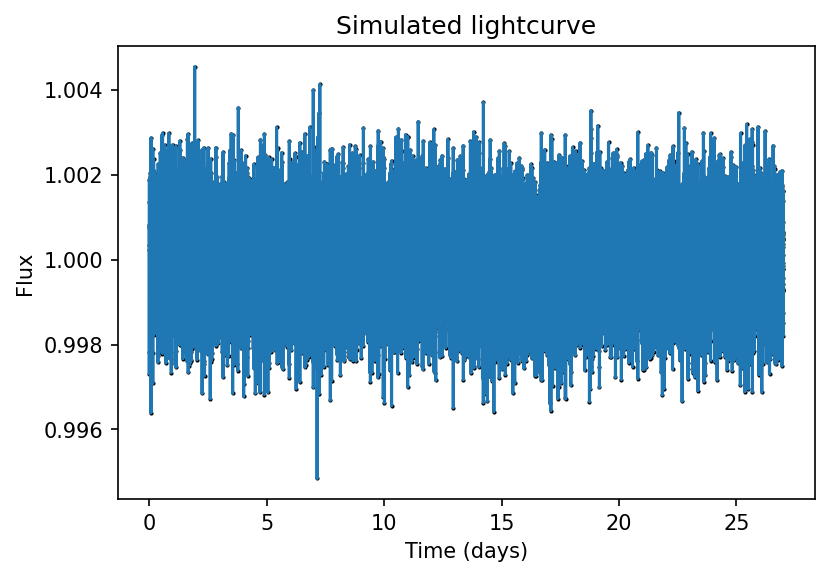

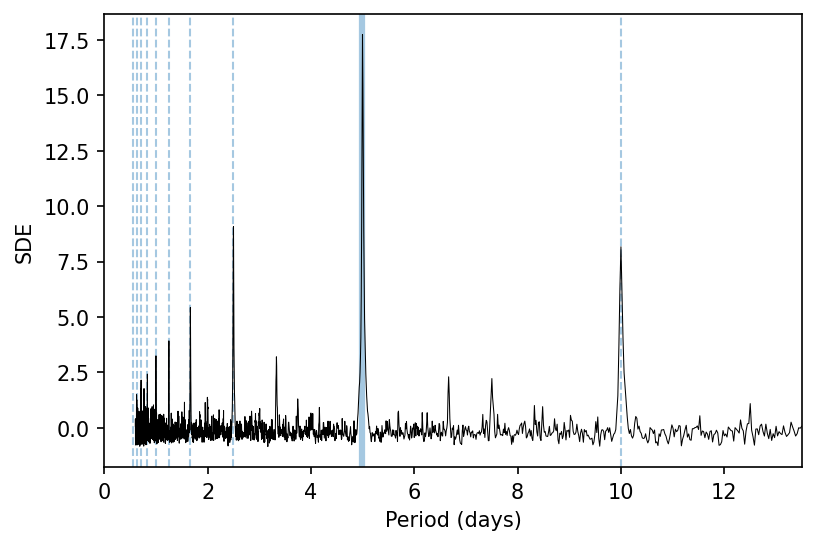

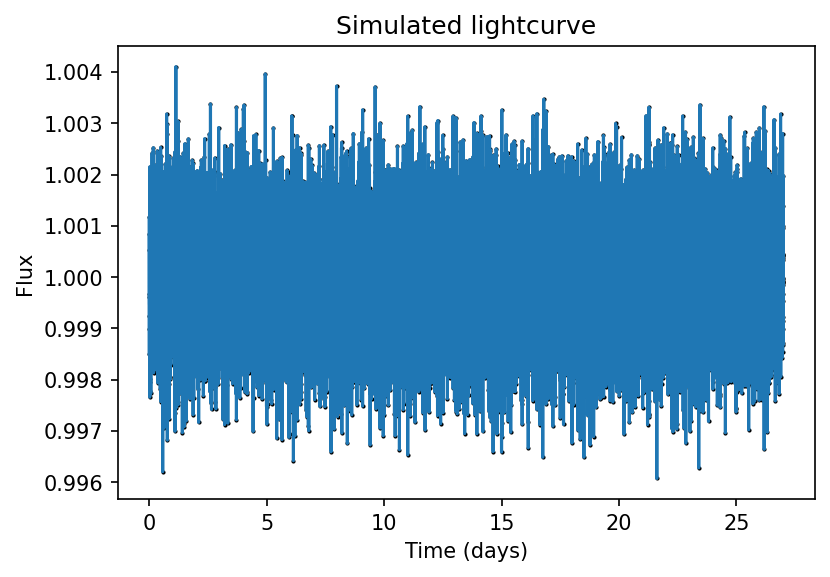

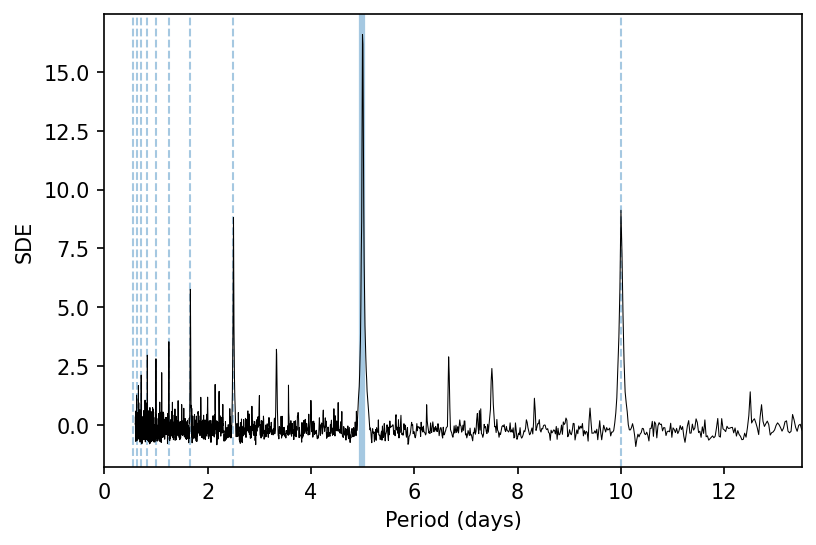

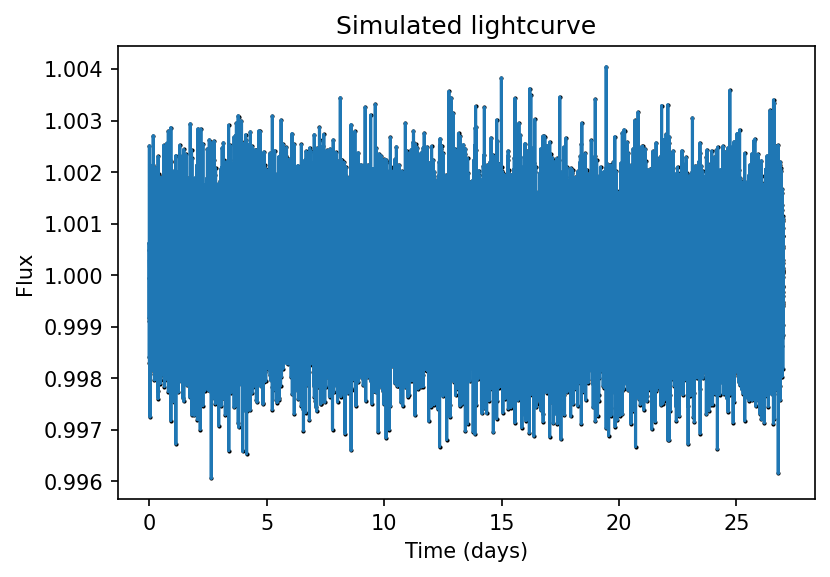

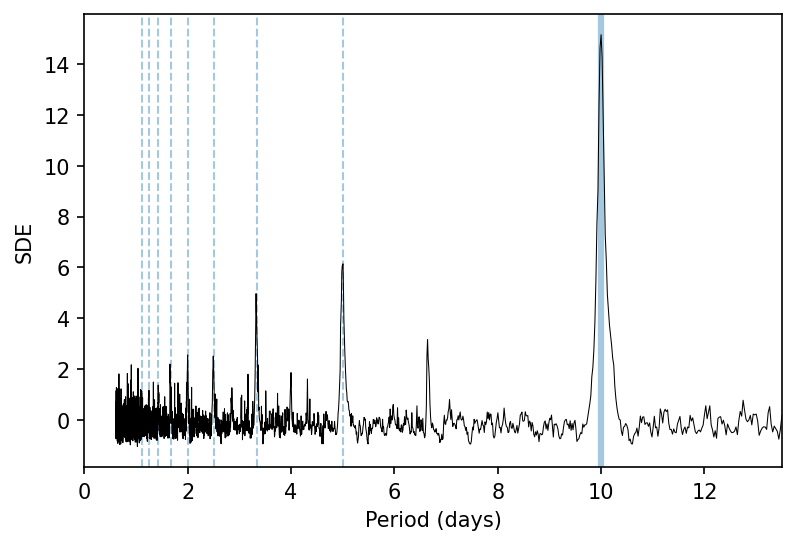

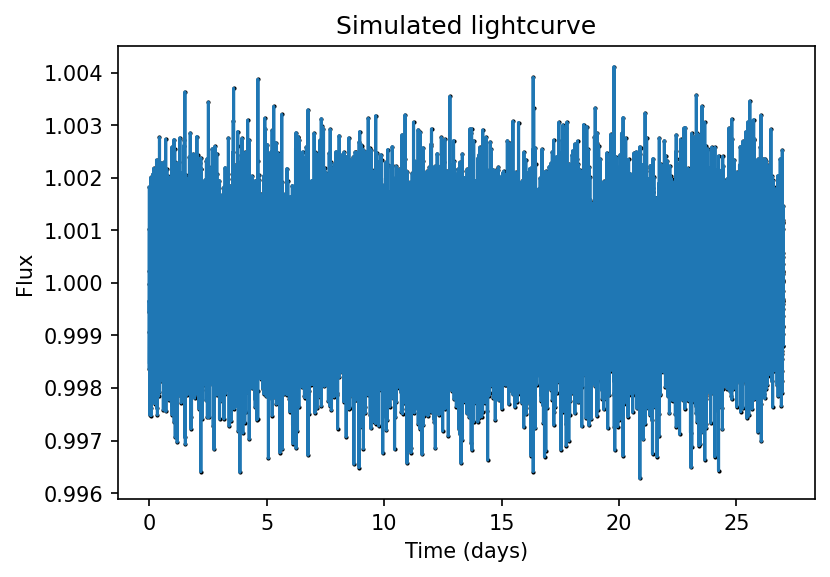

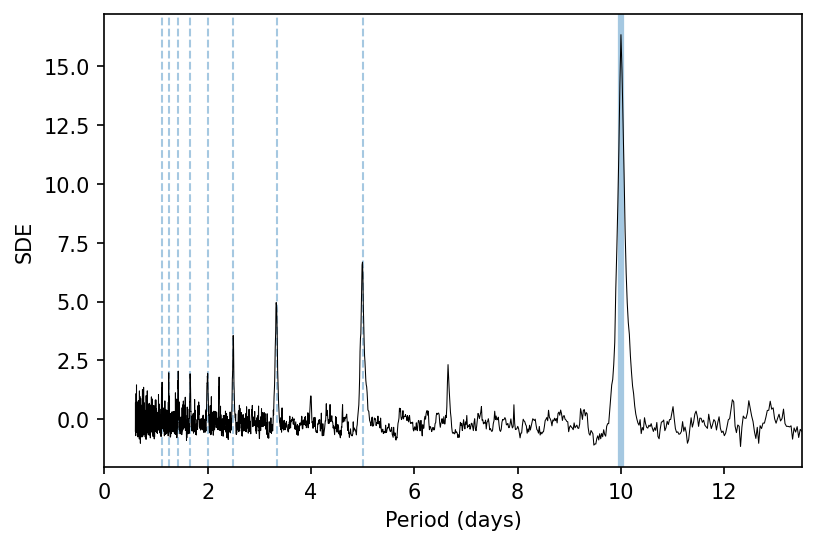

In [6]:
input_periods_array = np.array([])
periods_array = np.array([])
rp_over_rstar_range = np.array([])
detection_array = np.array([])
periods_array = np.array([])
FAP_array = np.array([])
periods_for_heatmap = np.array([])
ronr_for_heatmap = np.array([])
detection_for_heatmap = np.array([])
    
    
def find_period(period, rp_over_rstar):
    
    global periods_array, rand_phases, detection_array, FAP_array
    
    #Enter parameters
    period = period
    rp_over_rstar = rp_over_rstar
    a_over_rstar = period^(2/3) / 
    inc = 90.
    error_amount = 10 ** (-3) #per point error this s the transit depth of the earth around the star

    params = [period, rp_over_rstar, a_over_rstar]
    
    #Make colored Noise
    colored_noise = ColoredNoise(beta=-1,t=27, rng=None) #t is right hand endpoint, -1=blue 2=red 1=pink -2=violet 0=white


    cmag = error_amount /.007 #i believe the error is automatically at .007 compared to my error function, just from eyeballing
    cnoise = colored_noise.sample(19439)
    flux_err = cnoise * cmag

    #time array
    time = np.linspace(0,27,19441)


     #Batman
    from matplotlib import rcParams; rcParams["figure.dpi"] = 150

    # Create test data
    time_start = 0 # time to start first transit
    data_duration = 27
    samples_per_day = 720
    samples = int(data_duration * samples_per_day)
    time = np.linspace(0, data_duration, samples)

    # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
    ma.per = period  # orbital period in days
    ma.rp = rp_over_rstar  # 6371 planet radius (in units of stellar radii)
    ma.a = a_over_rstar  # semi-major axis (in units of stellar radii)
    ma.inc = inc  # orbital inclination (in degrees)
    ma.ecc = 0.  # eccentricity
    ma.w = 0.  # longitude of periastron (in degrees)
    ma.u = [0.0, 0.0]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    # Create noise and merge with flux

    flux = synthetic_signal + flux_err

    # Plot Batman flux array (points)
    plt.figure()
    ax = plt.gca()
    ax.scatter(time, flux, color='black', s=1)
    plt.title('Simulated lightcurve')
    ax.set_ylabel("Flux")
    ax.set_xlabel("Time (days)")

    plt.plot(time, flux)

    # Running transit least squares
    leastsquares = transitleastsquares(time, flux)#binned:(time_bin, flux_bin)
    results = leastsquares.power()


    # Showing the batman plot

    plt.figure()
    ax = plt.gca()
    ax.axvline(results.period, alpha=0.4, lw=3)
    plt.xlim(np.min(results.periods), np.max(results.periods))
    for n in range(2, 10):
        ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
        ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
    plt.ylabel(r'SDE')
    plt.xlabel('Period (days)')
    plt.plot(results.periods, results.power, color='black', lw=0.5)
    plt.xlim(0, max(results.periods))

    periods_array = np.append(periods_array, results.period)
    FAP_array = np.append(FAP_array,results.FAP) #if greater than 10^(-4)
    
    return FAP_array

    if results.FAP < .0001 and period *.99 < results.period < period* 1.01:
        detection_array = np.append(detection_array, 1)
    else:
        detection_array = np.append(detection_array, 0)

#generate n periods
period = 0
how_many_periods = int(input("How many periods? "))

for x in range(0,how_many_periods):
    period = period + 5
    input_periods_array = np.append(input_periods_array, period)
print(input_periods_array)
    
#generate n rp_over_rstars
rp_over_rstar = .015 
how_many_rp_over_rstars = int(input("How many rp_over_rstars? "))

for x in range(0,how_many_rp_over_rstars):
    rp_over_rstar = rp_over_rstar + .0005
    rp_over_rstar_range = np.append(rp_over_rstar_range, rp_over_rstar)
print(rp_over_rstar_range)
    
    
    
#run TLS n times for each pair 
times_to_run_each_block = input("How many times to run each block? ")

for x in input_periods_array:
    for y in rp_over_rstar_range:
        for each in range (0,1):
            find_period(x, y)
        periods_for_heatmap = np.append(periods_for_heatmap, x)
        ronr_for_heatmap = np.append(ronr_for_heatmap, y)
        detection_percent = sum(detection_array) / 10
        detection_for_heatmap = np.append(detection_for_heatmap, detection_percent)
        print(detection_array)
        detection_array = ([])

        
        
print(periods_for_heatmap)
print()
print(ronr_for_heatmap)
print(detection_for_heatmap)
#print(FAP_array)


In [ ]:
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)

In [ ]:
print("periods:" , periods_for_heatmap)
print("ronr:" , ronr_for_heatmap)
print("percent found:" , detection_for_heatmap)
#print(FAP_array)

data = pd.DataFrame({'RonR': ronr_for_heatmap, 'Periods': periods_for_heatmap, 'Detection': detection_for_heatmap})
data_pivoted = data.pivot("RonR", "Periods", "Detection")
data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")
#pd.plot(kind='RonR',rot=0)

plt.title("Blue noise transit detection rate")
data_pivoted.collections[0].colorbar.set_label("Percent found")
plt.show()

In [ ]:

    #Enter parameters
    period = period
    rp_over_rstar = rp_over_rstar
    a_over_rstar =  period **(2/3) #assuming sunlike star #19.53338 if M/2 and R/2
    inc = 90.
    error_amount = 10 ** (-3) #per point error this s the transit depth of the earth around the star

    params = [period, rp_over_rstar, a_over_rstar, inc]

#     #gaussian noise array
#     flux_err = np.array([])
#     for timestep in range(1,19441):
#         noise = random.normal(0,error_amount)
#         flux_err = np.append(flux_err, noise)

    #Make colored Noise
    colored_noise = ColoredNoise(beta=-1,t=27, rng=None) #t is right hand endpoint, -1=blue 2=red 1=pink -2=violet 0=white


    cmag = error_amount /.007 #i believe the error is automatically at .007 compared to my error function, just from eyeballing
    cnoise = colored_noise.sample(19439)
    flux_err = cnoise * cmag

    #time array
    time = np.linspace(0,27,19441)


     #Batman
    from matplotlib import rcParams; rcParams["figure.dpi"] = 150

    # Create test data
    time_start = 0 # time to start first transit
    data_duration = 27
    samples_per_day = 720
    samples = int(data_duration * samples_per_day)
    time = np.linspace(0, data_duration, samples)

    # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
    ma.per = period  # orbital period
    ma.rp = rp_over_rstar  # 6371 planet radius (in units of stellar radii)
    ma.a = a_over_rstar  # semi-major axis (in units of stellar radii)
    ma.inc = inc  # orbital inclination (in degrees)
    ma.ecc = 0.  # eccentricity
    ma.w = 0.  # longitude of periastron (in degrees)
    ma.u = [0.0, 0.0]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    # Create noise and merge with flux

    flux = synthetic_signal + flux_err

    # Plot Batman flux array (points)
    plt.figure()
    ax = plt.gca()
    ax.scatter(time, flux, color='black', s=1)
    plt.title('Simulated lightcurve (Correlated Noise)')
    ax.set_ylabel("Flux")
    ax.set_xlabel("Time (days)")

    plt.plot(time, flux)
    plt.plot(time, synthetic_signal)

    

In [ ]:
# Running transit least squares
leastsquares = transitleastsquares(time, flux)#binned:(time_bin, flux_bin) #unbinned: (time, lc_w_noise)
results = leastsquares.power()


# Showing the batman plot

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

periods_array = np.append(periods_array, results.period)
FAP_array = np.append(FAP_array,results.FAP) #if greater than 10^(-4)

if results.FAP < .0001 and period *.99 < results.period < period* 1.01:
    detection_array = np.append(detection_array, 1)
else:
    detection_array = np.append(detection_array, 0)